Loading Google News Word2Vec model... (this is ~1.5GB, may take time)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.5513 - loss: 6.8259 - val_accuracy: 0.7100 - val_loss: 3.5142 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.6846 - loss: 2.8880 - val_accuracy: 0.7350 - val_loss: 1.5107 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.7396 - loss: 1.2893 - val_accuracy: 0.7750 - val_loss: 0.8217 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.7584 - loss: 0.7831 - val_accuracy: 0.7900 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.7878 - loss: 0.6104 - val_accuracy: 0.7400 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.7764 - loss: 0.5744 - val_accuracy: 0.7900 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.8082 - loss: 0.5318 - val_

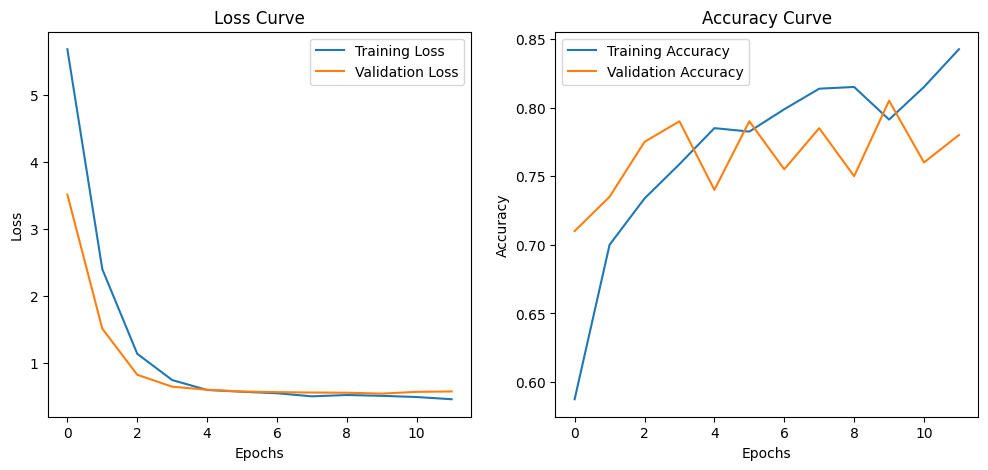

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8211    0.7800    0.8000       100
           1     0.7905    0.8300    0.8098       100

    accuracy                         0.8050       200
   macro avg     0.8058    0.8050    0.8049       200
weighted avg     0.8058    0.8050    0.8049       200



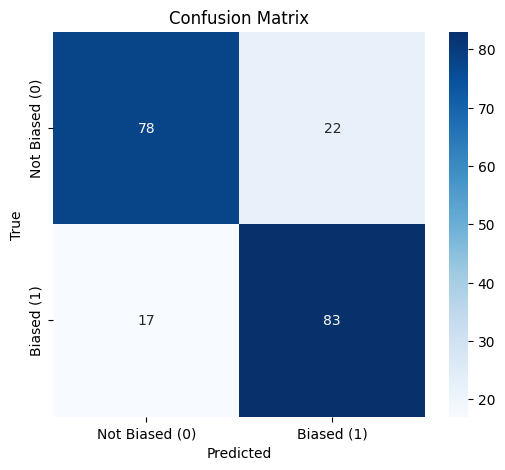

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import gensim.downloader as api   # NEW: load pretrained embeddings

# ===== 1. Load dataset =====
data = pd.read_csv("balanced_dataset.csv")
texts = data['title'].astype(str).tolist()
labels = data['isBiased'].values

# ===== 2. Tokenization =====
max_words = 8000
max_len = 120

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# ===== 3. Train/Validation Split =====
X_train, X_val, y_train, y_val = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# ===== 4. Load Pretrained Word2Vec (Google News) =====
print("Loading Google News Word2Vec model... (this is ~1.5GB, may take time)")
w2v_model = api.load("word2vec-google-news-300")
embedding_dim = 300

# ===== 5. Build Embedding Matrix =====
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words and word in w2v_model.key_to_index:
        embedding_matrix[i] = w2v_model[word]

# ===== 6. Define LSTM model with Word2Vec embeddings =====
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),   # keep frozen, set True if you want fine-tuning
    Bidirectional(LSTM(128, return_sequences=False,
                       dropout=0.1, recurrent_dropout=0.1,
                       kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# ===== 7. Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

# ===== 8. Train =====
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,   # smaller batch size for generalization
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ===== 9. Plot Training vs Validation Loss/Accuracy =====
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# ===== 10. Evaluation =====
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Biased (0)', 'Biased (1)'],
            yticklabels=['Not Biased (0)', 'Biased (1)'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
